## **Coincident NASA remote sensing data over the Arctic ocean**
### Search and subset data by geographic bounding box

Intro to use case (studying melt pond characteristics), motivation, connections to cloud migration, 

### Learning objectives:
1. Select NASA Earthdata sea ice and sea surface temperature datasets
2. Identify data file size and availability over time and geographic bounding box
3. Subset and download data using an Application Programmtic Interface (API)
4. Plot and compare coincident data values

___
### **Explore NASA Earthdata sea ice and ocean products**

- Highlight key search terms and data availability across NASA DAACs.

[NASA Earthdata Search results from SST and sea ice height keyword selection](https://search.earthdata.nasa.gov/search?fs10=Sea%20Ice%20Elevation&fsm0=Sea%20Ice&fst0=Cryosphere&fs21=Skin%20Sea%20Surface%20Temperature&fs11=Sea%20Surface%20Temperature&fsm1=Ocean%20Temperature&fst1=Oceans)

That's still 24 different data products to sort through and understand! We've done the selection for you, choosing L3A height data from the ATLAS instrument onboard ICESat-2 mission and Global Skin Sea Surface Temperature from the MODIS instrument onboard Terra. 

Links to landing pages and documentation:

- Sea Surface Temperature: 
    * MODIS (Terra) SST: MODIS_T-JPL-L2P-v2014.0
        - **Mention of SST data being restricted here?**
    * Hooked up to L2SS now:
        * C1940473819-POCLOUD (MODIS_A-JPL-L2P-v2019.0)
        * C1940475563-POCLOUD (MODIS_T-JPL-L2P-v2019.0)
        * C1940466008-POCLOUD (MERGED_TP_J1_OSTM_OST_CYCLES_V42)
- Sea Ice Height
    * [ATL07](https://doi.org/10.5067/ATLAS/ATL07.003)



___
### **Import packages**

In [10]:
import netrc
from urllib import request, parse
from http.cookiejar import CookieJar
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from pprint import pprint
import getpass
import requests
import json
import random
from statistics import mean
import pandas as pd
import geopandas
import os
from xml.etree import ElementTree as ET
import shutil
import time
import zipfile
import io
import xarray as xr
import h5py
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

___ 

### **Earthdata Login Authentication**

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is to create and only takes a moment to set up.

The function below will allow Python scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine uat.urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 


In [4]:
def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.

    Production endpoint:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

Now call the above function to set up Earthdata Login for subsequent requests:

In [11]:
setup_earthdata_login_auth('uat.earthdata.nasa.gov')

Please provide your Earthdata Login credentials to allow data access
Your credentials will only be passed to uat.earthdata.nasa.gov and will not be exposed in Jupyter


Username: amy.steiker
 ·········


___

### **Data Discovery**

We will be working with a study area just north of Greenland in the Arctic Ocean. The OpenAltimetry application provides on-the-fly visualizations of height measurements produced by ICESat-2, where interesting features can be tagged and shared, like this melt pond observation:

https://openaltimetry.org/data/icesat2/?start_date=2019-06-22&annoId=180

<img align="left"
     src="OpenAltimetry-study-area.png">


#### Record time and area of interest 

These `bounding_box` and `temporal` variables will be used for data search, subset, and access below

In [28]:
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
bounding_box = '-62.8,81.7,-56.4,83'
# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2019-06-22T00:00:00Z,2019-06-22T23:59:59Z'

#### Explore data availability using the Common Metadata Repository
The Common Metadata Repository (CMR) is a robust metadata system that catalogs Earth Science data and associated service metadata records. CMR supports data search and discovery through an Application Programming Interface, or API, enabling reproducible data product and data file searches using a number of helpful variables, including geographic area, keyword, and time.

General CMR API documentation: https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html

***[below is background for development - will not include in final notebook]***

_Configure a CMR GraphQL client:_

_Using qgl we can communicate with the CMR GraphQL endpoint in a standards-based way, allowing for schema introspection. gql isn't the only python GraphQL client library out there. Other libraries might provide features you value, like gql-next's static type generation functionality._

_GraphQL endpoint documentation and interactive playground:_ https://graphql.earthdata.nasa.gov/api


In [12]:
CMR_GRAPHQL_URL = 'https://graphql.earthdata.nasa.gov/api'
sample_transport=RequestsHTTPTransport(
    url=CMR_GRAPHQL_URL,
    retries=3,            # Automatically retry, don't put it on the user!
)

client = Client(
    transport=sample_transport,
    fetch_schema_from_transport=True,  # Get the schema as part of the client object
)

# collection_schema = client.schema.get_type('Collection')

# # Show info about 5 random fields
# sample_fields = random.sample(list(collection_schema.fields.items()), 5)
# for fieldname, field in sample_fields:
#     print(f'* {fieldname}: {field.description}')

#### Select data sets and determine version numbers
    
NASA Earthdata Search can be used to visualize file coverage over mulitple data sets and to access the same data you will be working with below: [insert URL with same search here]

Data sets are selected by data set IDs (e.g. ATL07). In the CMR API documentation, a data set id is referred to as a "short name". These short names are located at the top of each NSIDC data set landing page in gray above the full title. Data are then converted to JSON format; a language independant human-readable open-standard file format. More than one version can exist for a given data set:

In [20]:
sst_query = gql('''
query { 
  collections(shortName: "MODIS_T-JPL-L2P-v2019.0") {
    items { 
      shortName
      datasetId
      conceptId
      versionId
    }
  }
}
''')

sst_response = client.execute(sst_query)
pprint(sst_response)

height_query = gql('''
query { 
  collections(shortName: "ATL07") {
    items { 
      shortName
      datasetId
      conceptId
      versionId
    }
  }
}
''')

height_response = client.execute(height_query)
pprint(height_response)


{'collections': {'items': [{'conceptId': 'C1693233387-PODAAC',
                            'datasetId': 'GHRSST Level 2P Global Sea Surface '
                                         'Skin Temperature from the Moderate '
                                         'Resolution Imaging Spectroradiometer '
                                         '(MODIS) on the NASA Terra satellite '
                                         '(GDS2)',
                            'shortName': 'MODIS_T-JPL-L2P-v2019.0',
                            'versionId': '2019.0'}]}}
{'collections': {'items': [{'conceptId': 'C1631076780-NSIDC_ECS',
                            'datasetId': 'ATLAS/ICESat-2 L3A Sea Ice Height '
                                         'V002',
                            'shortName': 'ATL07',
                            'versionId': '002'},
                           {'conceptId': 'C1706334166-NSIDC_ECS',
                            'datasetId': 'ATLAS/ICESat-2 L3A Sea Ice Height '
         

We will specify the most recent version for our remaining data set queries.

#### Discover file number and file size 

Again using CMR search, determine the number of files that exist over this time and area of interest, as well as the average size and total volume of those files.

In [24]:
# NOTE: GraphQL endpoint currently supports selecting granules by conceptId, not short_name, versionId.
query = gql('''
query {
  granules(conceptId: "C1940475563-POCLOUD"
           boundingBox: "-62.8,81.7,-56.4,83"
           temporal: "2019-06-22T00:00:00Z,2019-06-22T23:59:59Z"
           limit: 100) {
    count
    items { granuleSize }
           
  }
}
''')
response = client.execute(query)

granule_sizes = [float(i['granuleSize']) for i in response['granules']['items']][:]

print(f"Found {response['granules']['count']} files")
print(f"Average size: {mean(granule_sizes):.2f}")
print(f"Total size: {sum(granule_sizes):.2f}")

Found 0 files


StatisticsError: mean requires at least one data point

#### ***On your own: Discover data availability for MODIS Skin Sea Surface Temperature:***
Replace the ATL07 `conceptID` value with the MODIS Skin Sea Surface Temperature `conceptID` value returned above. How do the number of files and the data volume compare to ATL07?

Note that subsetting, reformatting, or reprojecting can alter the size of the granules if those services are applied to your request.



### **Data Access and Subsetting**

#### Determine subsetting service options

Let's execute one final CMR search to determine what transformation services, such as spatial subsetting, reformatting, reprojection, and resampling, are available for each data product. 

In [25]:
height_query = gql('''
query { 
  collections(conceptId: "C1706334166-NSIDC_ECS") {
    items { 
      shortName
      datasetId
      conceptId
      versionId
      services {
          items {
          serviceOptions
          }
      }
    }
  }
}
''')

height_response = client.execute(height_query)
pprint(height_response['collections'])

{'items': [{'conceptId': 'C1706334166-NSIDC_ECS',
            'datasetId': 'ATLAS/ICESat-2 L3A Sea Ice Height V003',
            'services': {'items': [{'serviceOptions': {'subset': {'spatialSubset': {'boundingBox': {'allowMultipleValues': False},
                                                                                    'shapefile': [{'format': 'ESRI'},
                                                                                                  {'format': 'KML'},
                                                                                                  {'format': 'GeoJSON'}]},
                                                                  'temporalSubset': {'allowMultipleValues': False},
                                                                  'variableSubset': {'allowMultipleValues': True}},
                                                       'supportedReformattings': [{'supportedInputFormat': 'HDF5',
                                               

We can also do this for the MODIS SST data set (pending UMM-S and L2SS connection?)

In [26]:
sst_query = gql('''
query { 
  collections(conceptId: "C1940475563-POCLOUD") {
    items { 
      shortName
      datasetId
      conceptId
      versionId
      services {
          items {
          serviceOptions
          }
      }
    }
  }
}
''')

sst_response = client.execute(sst_query)
pprint(sst_response['collections'])

{'items': []}


For our purposes, even though there are several other options for spatial area input like shapefile (see other tutorial for this!), we'll use a simple bounding box to crop our data to that area. 

### Data Access

Prior to migrating to AWS, ATL07 is accessed using an NSIDC-specific API:

In [29]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

# bounding box search and subset:
param_dict = {'short_name': 'ATL07', 
              'version': '003', 
              'temporal': temporal, 
              'bounding_box': bounding_box, 
              'bbox': bounding_box, 
              'page_size': '10', 
              'request_mode': 'async',
              'email': 'amy.steiker@nsidc.org', }

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

API_request = api_request = f'{base_url}?{param_string}'
print(API_request)

https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL07&version=003&temporal=2019-06-22T00:00:00Z,2019-06-22T23:59:59Z&bounding_box=-62.8,81.7,-56.4,83&bbox=-62.8,81.7,-56.4,83&page_size=10&request_mode=async&email=amy.steiker@nsidc.org


Earthdata Search session (from https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+Python):

In [32]:
username = 'amy.steiker' # Enter Earthdata Login user name'
password = getpass.getpass('Earthdata Login password: ') # Enter Earthdata Login password

Earthdata Login password:  ·········


In [38]:
path = str(os.getcwd() + '/Outputs') # Create an output folder if the folder does not already exist.
if not os.path.exists(path):
    os.mkdir(path)
        
with requests.Session() as session:
    session.auth = (username, password)
    r = session.get(API_request)
    if r.ok:
        print('Order request URL: ', r.url)
        esir_root = ET.fromstring(r.content)
        orderlist = []   # Look up order ID
        for order in esir_root.findall("./order/"):
            orderlist.append(order.text)
        orderID = orderlist[0]
        print('order ID: ', orderID)
        statusURL = base_url + '/' + orderID # Create status URL
        print('status URL: ', statusURL)
        request_response = session.get(statusURL) # Find order status  
        if request_response.ok:        
            request_root = ET.fromstring(request_response.content)
            statuslist = []
            for status in request_root.findall("./requestStatus/"):
                statuslist.append(status.text)
            status = statuslist[0]
            print('Initial request status is ', status)
        while status == 'pending' or status == 'processing': #Continue loop while request is still processing
            print('Status is not complete. Trying again...')
            time.sleep(10)
            loop_response = session.get(statusURL)
            loop_response.raise_for_status() # Raise bad request: Loop will stop for bad response code.
            loop_root = ET.fromstring(loop_response.content)
            statuslist = [] #find status
            for status in loop_root.findall("./requestStatus/"):
                statuslist.append(status.text)
            status = statuslist[0]
            print('Retry request status is: ', status)
            if status == 'pending' or status == 'processing':
                continue
        if status == 'complete_with_errors' or status == 'failed': # Provide complete_with_errors error message:
            messagelist = []
            for message in loop_root.findall("./processInfo/"):
                messagelist.append(message.text)
            print('error messages:')
            pprint(messagelist)
        if status == 'complete' or status == 'complete_with_errors':# Download zipped order if status is complete or complete_with_errors
            downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
            print('Zip download URL: ', downloadURL)
            print('Beginning download of zipped output...')
            zip_response = session.get(downloadURL)
            zip_response.raise_for_status() # Raise bad request: Loop will stop for bad response code.
            with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
                z.extractall(path)
            print('Data request is complete.')
        else: print('Request failed.')

Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL07&version=003&temporal=2019-06-22T00:00:00Z,2019-06-22T23:59:59Z&bounding_box=-62.8,81.7,-56.4,83&bbox=-62.8,81.7,-56.4,83&page_size=10&request_mode=async&email=amy.steiker@nsidc.org
order ID:  5000000923193
status URL:  https://n5eil02u.ecs.nsidc.org/egi/request/5000000923193
Initial request status is  processing
Status is not complete. Trying again.
Retry request status is:  complete
Zip download URL:  https://n5eil02u.ecs.nsidc.org/esir/5000000923193.zip
Beginning download of zipped output...
Data request is complete.


In [39]:
# Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
    for name in dirs:
        os.rmdir(os.path.join(root, name))

The MODIS SST data can be subsetted via Harmony subsetting service. (Insert Harmony landing page when available!!)

In [40]:
harmony_root = 'https://harmony.earthdata.nasa.gov'

bboxSubsetConfig = {
    'collection_id': 'C1940475563-POCLOUD',
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'lat': '(81.7:83)',
    'lon': '(-62.8:-56.4)',
    'time': '("2019-06-22T00:00:00Z":"2019-06-22T23:59:59Z")'
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?&subset=lat{lat}&subset=lon{lon}&subset=time{time}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)
r = session.get(bbox_url)
bbox_response = r.content
async_json = json.loads(bbox_response)
pprint(async_json)


jobConfig = {
    'jobID': async_json['jobID']
}

job_url = harmony_root+'/jobs/{jobID}'.format(**jobConfig)
print('Job URL', job_url)

job_response = session.get(job_url)
job_results = job_response.content
job_json = json.loads(job_results)

print('Job response:')
print()
pprint(job_json)


#Continue loop while request is still processing
while job_json['status'] == 'running' and job_json['progress'] < 100: 
    print('Job status is running. Progress is ', job_json['progress'], '%. Trying again.')
    time.sleep(10)
    loop_response = session.get(job_url)
    loop_results = loop_response.content
    job_json = json.loads(loop_results)
    if job_json['status'] == 'running':
        continue

if job_json['progress'] == 100:
    print('Job progress is 100%. Output links printed below:')
    links = [link for link in job_json['links'] if link.get('rel', 'data') == 'data'] #list of data links from response
    for i in range(len(links)):
        link_dict = links[i] 
        print(link_dict['href'])
        filepath = link_dict['href'].split('/')[-1]
        file_ = open(filepath, 'wb')
        response = session.get(link_dict['href'])
        file_.write(response.content)
        file_.close()

Request URL https://harmony.earthdata.nasa.gov/C1940475563-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?&subset=lat(81.7:83)&subset=lon(-62.8:-56.4)&subset=time("2019-06-22T00:00:00Z":"2019-06-22T23:59:59Z")
{'createdAt': '2020-11-16T00:44:27.910Z',
 'jobID': '90619130-355c-4b13-9c52-afbe6f3cc5c4',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/90619130-355c-4b13-9c52-afbe6f3cc5c4',
            'rel': 'self',
            'title': 'Job Status',
            'type': 'application/json'}],
 'message': 'The job is being processed',
 'progress': 0,
 'request': 'https://harmony.earthdata.nasa.gov/C1940475563-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=lat(81.7%3A83)&subset=lon(-62.8%3A-56.4)&subset=time(%222019-06-22T00%3A00%3A00Z%22%3A%222019-06-22T23%3A59%3A59Z%22)',
 'status': 'running',
 'updatedAt': '2020-11-16T00:44:27.910Z',
 'username': 'amy.steiker'}
Job URL https://harmony.earthdata.nasa.gov/jobs/90619130-355c-4b13-9c52-

### **Data Plotting and Comparison** 

File 20190622192501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_subsetted.nc has data - some granules do not contain any data.

In [121]:
filepath = './20190622192501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_subsetted.nc' # Define local filepath 

sst = xr.open_dataset(filepath)
list(sst.variables)

['lat',
 'lon',
 'sea_surface_temperature',
 'sst_dtime',
 'quality_level',
 'sses_bias',
 'sses_standard_deviation',
 'l2p_flags',
 'chlorophyll_a',
 'K_490',
 'wind_speed',
 'dt_analysis',
 'time']

In [42]:
atl_filepath = './Outputs/processed_ATL07-01_20190622200154_13070301_003_02.h5' # Define local filepath 

VARIABLES = {
    'ATL07': [
        '/gt1l/sea_ice_segments/delta_time',
        '/gt1l/sea_ice_segments/latitude',
        '/gt1l/sea_ice_segments/longitude',
        '/gt1l/sea_ice_segments/heights/height_segment_confidence',
        '/gt1l/sea_ice_segments/heights/height_segment_height',
        '/gt1l/sea_ice_segments/heights/height_segment_quality',
        '/gt1l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt1l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt2l/sea_ice_segments/delta_time',
        '/gt2l/sea_ice_segments/latitude',
        '/gt2l/sea_ice_segments/longitude',
        '/gt2l/sea_ice_segments/heights/height_segment_confidence',
        '/gt2l/sea_ice_segments/heights/height_segment_height',
        '/gt2l/sea_ice_segments/heights/height_segment_quality',
        '/gt2l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt2l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt3l/sea_ice_segments/delta_time',
        '/gt3l/sea_ice_segments/latitude',
        '/gt3l/sea_ice_segments/longitude',
        '/gt3l/sea_ice_segments/heights/height_segment_confidence',
        '/gt3l/sea_ice_segments/heights/height_segment_height',
        '/gt3l/sea_ice_segments/heights/height_segment_quality',
        '/gt3l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt3l/sea_ice_segments/heights/height_segment_length_seg']
}

In [43]:
def load_icesat2_as_dataframe(filepath, VARIABLES):
    '''
    Load points from an ICESat-2 granule 'gt<beam>' groups as DataFrame of points. Uses VARIABLES mapping
    to select subset of '/gt<beam>/...' variables  (Assumes these variables share dimensions)
    Arguments:
        filepath to ATL0# granule
    '''
    
    ds = h5py.File(filepath, 'r')

    # Get dataproduct name
    dataproduct = ds.attrs['identifier_product_type'].decode()
    # Convert variable paths to 'Path' objects for easy manipulation
    variables = [Path(v) for v in VARIABLES[dataproduct]]
    # Get set of beams to extract individially as dataframes combining in the end
    beams = {list(v.parents)[-2].name for v in variables}
    
    dfs = []
    for beam in beams:
        data_dict = {}
        beam_variables = [v for v in variables if beam in str(v)]
        for variable in beam_variables:
            # Use variable 'name' as column name. Beam will be specified in 'beam' column
            column = variable.name
            variable = str(variable)
            try:
                values = ds[variable][:]
                # Convert invalid data to np.nan (only for float columns)
                if 'float' in str(values.dtype):
                    if 'valid_min' in ds[variable].attrs:
                        values[values < ds[variable].attrs['valid_min']] = np.nan
                    if 'valid_max' in ds[variable].attrs:
                        values[values > ds[variable].attrs['valid_max']] = np.nan
                    if '_FillValue' in ds[variable].attrs:
                        values[values == ds[variable].attrs['_FillValue']] = np.nan
                    
                data_dict[column] = values
            except KeyError:
                print(f'Variable {variable} not found in {filepath}. Likely an empty granule.')
                raise
                
        df = pd.DataFrame.from_dict(data_dict)
        df['beam'] = beam
        dfs.append(df)
        
    df = pd.concat(dfs, sort=True)
    # Add filename column for book-keeping and reset index
    df['filename'] = Path(filepath).name
    df = df.reset_index(drop=True)
    
    return df

In [44]:
atl07 = load_icesat2_as_dataframe(atl_filepath, VARIABLES)
atl07.tail()

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename
42559,gt3l,4.647045e+07,0.011723,0.591261,17.936722,1,0.024832,82.177667,-58.927473,processed_ATL07-01_20190622200154_13070301_003...
42560,gt3l,4.647045e+07,0.016459,0.430999,20.116600,1,0.026332,82.177605,-58.927597,processed_ATL07-01_20190622200154_13070301_003...
42561,gt3l,4.647045e+07,NaN,0.116308,30.875296,0,NaN,82.177523,-58.927759,processed_ATL07-01_20190622200154_13070301_003...
42562,gt3l,4.647045e+07,0.008099,-0.346326,41.622524,0,0.045033,82.177312,-58.928180,processed_ATL07-01_20190622200154_13070301_003...
42563,gt3l,4.647045e+07,NaN,-0.122129,29.271753,0,NaN,82.177207,-58.928390,processed_ATL07-01_20190622200154_13070301_003...


Convert sst data array to masked array:

In [134]:
import numpy.ma as ma

lon = ma.masked_invalid(sst['lon'])
lat = ma.masked_invalid(sst['lat'])
sst_array = ma.masked_invalid(sst['sea_surface_temperature'])

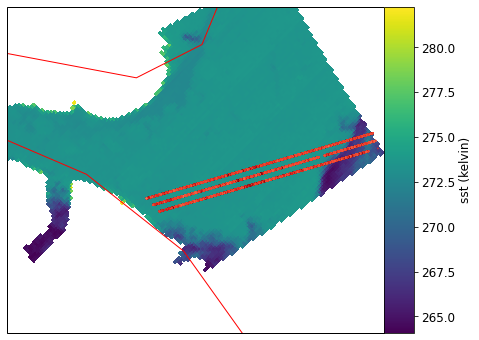

In [223]:
import cartopy
# adapted from https://bairdlangenbrunner.github.io/python-for-climate-scientists/matplotlib/pcolormesh-grid-fix.html
map_proj = cartopy.crs.NorthPolarStereo()
data_proj = cartopy.crs.PlateCarree()
#geodetic_proj = cartopy.crs.PlateCarree()

fig = plt.figure(figsize=(14,6))

ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(color='red')

sst_plot = ax.pcolor(lon,\
                      lat,\
                      sst_array[0],\
                      transform=data_proj)
#ax.set_extent([-65,-55,81,83.5])
#ax.set_extent([-75,-45,81,84])
ax.set_extent([-61.5,-56.5,81.8,83])

# add colorbar
axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x1+0,axpos.y0,0.03,axpos.height])
cbar = fig.colorbar(sst_plot, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('sst (kelvin)', fontsize=12)

height_plot = ax.scatter(atl07.longitude,\
                        atl07.latitude,\
                        c=atl07.height_segment_height,\
                        vmax=1.5,\
                        cmap='Reds',\
                        alpha=0.7,\
                        s=1,\
                        transform=data_proj)
# cbar2_ax = fig.add_axes([axpos.x1+0,axpos.y0,0.03,axpos.height])
# cbar2 = fig.colorbar(height_plot,cax=cbar2_ax)
# cbar2.ax.tick_params(labelsize=12)
# cbar2.set_label('ATL07 Height (m)',fontsize=12)

In [225]:
# # basic plot of atl07
# plt.subplots(figsize=(10,5)) # set size
# #plt.pcolormesh(sst_array[0], cmap='viridis')
# #plt.colorbar(label='SST (kelvin)')
# plt.scatter(atl07.longitude, atl07.latitude,
#           c=atl07.height_segment_height, vmax=1.5,
#           cmap='Reds', alpha=0.6, s=1)  
# plt.colorbar(label='ATL07 Height (m)')
# plt.show()

In [224]:
# #basic plot of sst
# plt.subplots(figsize=(10,5)) # set size
# sst['sea_surface_temperature'].plot(cmap='viridis');

# Move to different notebook: Point search testing...

Argo float data from [this search](https://nrlgodae1.nrlmry.navy.mil/cgi-bin/argo_select.pl?startyear=2020&startmonth=11&startday=01&endyear=2020&endmonth=11&endday=03&Nlat=75&Wlon=-80&Elon=-45&Slat=50&dac=ALL&floatid=ALL&gentype=plt&.submit=++Go++&.cgifields=endyear&.cgifields=dac&.cgifields=delayed&.cgifields=startyear&.cgifields=endmonth&.cgifields=endday&.cgifields=startday&.cgifields=startmonth&.cgifields=gentype)

Pull in file with lat lon point locations:

In [ ]:
df = pd.read_csv("argo-float-data.csv")
gdf = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.Longitude, df.Latitude))
gdf

In [ ]:
gdf.to_file('argo-data.geojson', driver='GeoJSON')

curl -XPOST "https://cmr.earthdata.nasa.gov/search/granules" -F "shapefile=@argo-data.geojson;type=application/geo+json" -F "collection_concept_id=C1706334166-NSIDC_ECS" -F "page_size=100"

In [ ]:
search_url = "https://cmr.earthdata.nasa.gov/search/granules"
files = {"shapefile": ("argo-data.geojson", open('argo-data.geojson', 'r'), "application/geo+json")}
parameters = {
    "scroll": "true",
    "page_size": 100,
    # set any search criteria here
    "collection_concept_id": "C1706334166-NSIDC_ECS",
}
output_format = "json"
response = requests.post(f"{search_url}.{output_format}", data=parameters, files=files)

print("status:", response.status_code)
print("hits:", response.headers["CMR-Hits"])
pprint(response.json()["feed"]["entry"][0])
